<div align="center">
	<br>
	<br>
  	<a href="http://mosig.imag.fr/">
		<img src="uga.jpg" width="400">
	</a>
    <h1><b>Fairness in Classification on the COMPAS datasets</b></h1>
    <h4><i>An analysis of the COMPAS software results using the ProPublica dataset.</i></h4>
    <h5><i>by AUFAUVRE Emilien & BANTIGNIES Hugo</i></h5>
</div>

<br>

---

# <b>1. Introduction</b>

In [1]:
from IPython.core.display import HTML
HTML(
"""
<style>
p 
{ 
    text-align: center;     
}
</style>
""")

# <b>2. Overview of the Data and biases</b>

The objective of this part is to show that the `COMPAS` scores have biases against certain racial groups. More precisely, we will take a look at the `Caucasian` and the `African-American` ones which are the most represented races. Also, we will look at the genders (`Male` and `Female`).

## 2.1. Initializing the data and environment

We first need to load the data from the `ProPublica` [repo](https://github.com/propublica/compas-analysis) **[1]**:

1. We first import the libraries that we will need:

In [2]:
import utils as utils
import os as os
import sys as sys
import numpy as np
import pandas as pd
import urllib as urllib
import matplotlib.pyplot as plt
import sklearn.linear_model as sklinear
import sklearn.ensemble as skensemble
import sklearn.svm as sksvm
import sklearn.model_selection as skselect
import sklearn.metrics as skmetrics

2. We define the project constants:

In [3]:
COMPAS_INPUT_FILE = "compas-scores-two-years.csv"
RANDOM_STATE = 0

3. Before we load the dataset on our host:

In [4]:
def check_data_file():
    """
    Download the COMPAS file if not already existing.
    """
    # Get the current directory listing.
    files = os.listdir(".") 
    print("Looking for file '%s' in the current directory...",
        COMPAS_INPUT_FILE)

    if COMPAS_INPUT_FILE not in files:
        print("'%s' not found! Downloading from GitHub...", 
             COMPAS_INPUT_FILE)
        # Get data from github repo.
        addr = "https://raw.githubusercontent.com/propublica/"\
               + "compas-analysis/master/compas-scores-two-years.csv"
        response = urllib.request.urlopen(addr)
        data = response.read()
        # Write in the file.
        fileOut = open(COMPAS_INPUT_FILE, "wb")
        fileOut.write(data)
        fileOut.close()    
        print("'%s' download and saved locally..",
             COMPAS_INPUT_FILE)
    else:
        print("File found in current directory..")

In [5]:
# Download the COMPAS file.
check_data_file()  
# Load data.
df = pd.read_csv(COMPAS_INPUT_FILE)

Looking for file '%s' in the current directory... compas-scores-two-years.csv
File found in current directory..


Not all of the rows of our dataset are useable for the first round of analysis. We do some _data cleaning_ using what `ProPublica` have already done **[1]**:
<br>
Here are the rows that we remove:
   * If the charge date of a `COMPAS` marked crime was not within 30 days of the person's arrest, we assume that due to the quality of the data, we do not have the correct offense. 
   * The ones for which we couldn't find an older `COMPAS` case (the recidivist flag _is_recid_ is set to -1) .
   * The traffic offenses which didn't end up in jail (the ones with _c\_charge_degree_ set to 0).
   * And the people who haven't recidivated in two years, and hadn't at least two years outside of a correctional facility.

Here is the corresponding code to load and clean our dataset:

In [6]:
def clean_dataset(df_):
    """
    Clean the dataset "df_" using the conditions above.
    """
    # Dropping missing values.
    df_ = df_.dropna(subset = ["days_b_screening_arrest"])
    # Filter the dataframe as said in the description above.
    df_ = df_[
        (df_.days_b_screening_arrest <= 30) &  
        (df_.days_b_screening_arrest >= -30) &  
        (df_.is_recid != -1) &
        (df_.c_charge_degree != 'O') &
        (df_.score_text != 'N/A')
    ]
    # Renumber the rows from 0 again.
    df_.reset_index(inplace = True, drop = True) 

In [7]:
clean_dataset(df)

Then we show some basic information about our dataset to check if everything is in order and familiarize with it:

In [8]:
# Print the number of entries and the number of attributes, 
# the first row of the dataframe, and the attributes.
print("\nShape:\n" + str(df.shape))
print("\nColumns:\n" + str(df.columns))
print("\nHead:\n" + str(df.head(n = 1)))


Shape:
(7214, 53)

Columns:
Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

Head:
   id        

## 2.2. Basic analysis of demographics

After initialization, we quickly observe to what the `COMPAS` data values look like to also familiarize with it.

* Here are the different _races_ present in the dataframe:

In [9]:
print(df.race.unique())

['Other' 'African-American' 'Caucasian' 'Hispanic' 'Native American'
 'Asian']


* Here are the number of people by age category (`25 - 45`, `Less than 25` and `Greater than 45`):

In [10]:
print(df.age_cat.value_counts())

25 - 45            4109
Greater than 45    1576
Less than 25       1529
Name: age_cat, dtype: int64


> The middle age category `25 - 45` is the most present.

* Here are the number of people by _race_ (`African-American`, `Caucasian`, `Hispanic`, `Asian`, `Native American`, and `Other`):

In [11]:
print(df.race.value_counts())

African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: race, dtype: int64


> `African-Americans` are the most represented, followed by the `Caucasians`.

* Here are the number of people by `COMPAS` _score_ (where score is in `[1, 10]`):

In [12]:
print(df.decile_score.value_counts())

1     1440
2      941
4      769
3      747
5      681
6      641
7      592
8      512
9      508
10     383
Name: decile_score, dtype: int64


> Most of people have a score under 5.

* Here are the number of people by `COMPAS` _risk category_ (`Low`, `Medium` and `High`):

In [13]:
print(df.score_text.value_counts())

Low       3897
Medium    1914
High      1403
Name: score_text, dtype: int64


> Most of people have a `Low` score.

## 2.3. Investigations of gender and race biases in COMPAS scores

After having fully adjusted and familiarized with the dataset, we would like to take a closer look to the _races_ (more precisely the `Caucasian` and the `African-American` ones) and _gender_ of this dataset.

### 2.3.1. Overview of the COMPAS score

Here is the mean of `COMPAS` _score_ per race and gender:

In [14]:
print(df.decile_score.groupby(df.race).mean())
print(df.decile_score.groupby(df.sex).mean())

race
African-American    5.368777
Asian               2.937500
Caucasian           3.735126
Hispanic            3.463108
Native American     6.166667
Other               2.949602
Name: decile_score, dtype: float64
sex
Female    4.172043
Male      4.590479
Name: decile_score, dtype: float64


> From these results we can say that `Native Americans` and `African-American` are from far the ones with highest scores, especially the first ones. However we should keep in mind that the size of the samples is not represented here. Also, `Females` have an average score a bit lower than the `Males` one.

We  now compute the distribution histogram of the `COMPAS` _score_ per _race_ and _gender_. For the _races_, as `ProPublica` did **[1]**, we display especially the distribution of the `Caucasian` and `African-American` since they hide the most interesting results for after:

In [15]:
def plot_decile_score_hist(groupby):
    """
    Plot the decile score histograms, grouped by groupby.
    """
    # Plot.
    ax = df.decile_score.hist(by = groupby, 
                bins = 19,
                grid = False,
                layout = (6, 2),
                figsize = (14, 24), 
                color = "darkred",
                rwidth = 1)
    # Decoration.
    for plot in ax:
        for x in plot:
            # Set labels + despine.
            utils.plt_decorate(x, 
                               "Distribution of the COMPAS score\namong the " 
                               + x.get_title() + "s",
                               "COMPAS Score", 
                               "Total People")

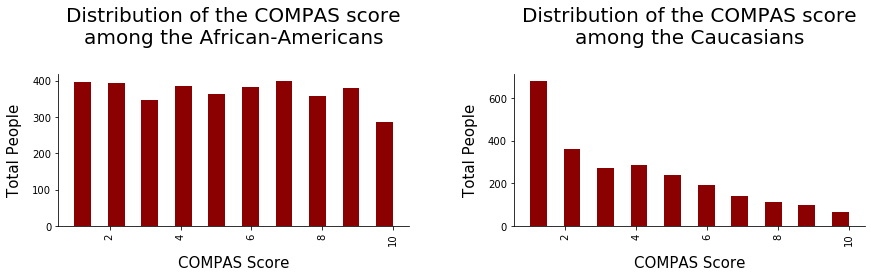

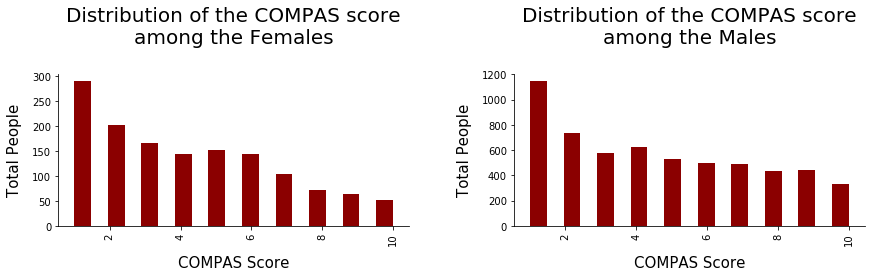

In [16]:
plot_decile_score_hist(df[(df.race == "Caucasian") | (df.race == "African-American")].race)
plot_decile_score_hist(df.sex)

> As we can see, the histograms are reflecting the data printed before. Depending on the number of people per race sample, the histograms are not the sames at all. The `African-Americans` seem to have flattened histogram, while the `Caucasians` have an histogram which gets smaller and smaller as it approaches the maximum score. Thus, it seems that these last defendants are likely to be judged at a low risk, while the `African-Americans` have more a distributed _score_.
<br>
Also, `Females` are clearly less represented than the `Males`. But we could observe a small tendency to be not judged as high risk as the `Males`.
<br>
We could already share some conclusions, nevertheless the data is not sufficient to sufficiently detail them.
<br>
<br>
> _From the non-plotted graphs: even if the `Native-American` had the highest score just before, we now remark that the sample for this race is not big enough to talk about it (only 11 people in the sample)._

### 2.3.2. Overview of the recidivism

We are now interested by the recidivism; we compute how many people were re-arrested (a person is re-arrested when _two_year_recid_ is set to 1):

In [17]:
re_arrested = df.two_year_recid.value_counts()[1]
print(re_arrested)

3251


Thus, the rate of person re-arrested among all the dataset is the following one:

In [18]:
print(re_arrested / df.shape[0] * 100)

45.06515109509287


> As we can see, in our dataset, almost one in two people get re-arrested.

Now we compute the recidivism rates by race and gender:

In [19]:
print(df.two_year_recid.groupby(df.race).mean() * 100)
print(df.two_year_recid.groupby(df.sex).mean() * 100)

race
African-American    51.433983
Asian               28.125000
Caucasian           39.364303
Hispanic            36.420722
Native American     55.555556
Other               35.278515
Name: two_year_recid, dtype: float64
sex
Female    35.698925
Male      47.310534
Name: two_year_recid, dtype: float64


>`African-American` are the ones with the highest rate of recidivism, and `Asian` the ones with the lowest, and from what we saw with the histograms just before, we could have imagine that `Caucasian` had a lower rate since most of them were assigned as `Low Risk`.
<br>
Also, `Males` have a higher rate than the `Females` which seems in agreement with the plotted distributions.

### 2.3.3. Meaning of predictions

Having seen the two variables that define the accuracy, we are now interested in seeing if put together, these variables are meaningful.
<br>
First, to have a general impression we would like to see the recidivism rate by `COMPAS` _score_. To do this we define the following function:

In [20]:
def plot_recidivism_by_decile_score():
    """
    Plot the recidivism rate by decile score.
    """
    # Plot.
    to_plot = df.two_year_recid.groupby(df.decile_score).mean() * 100
    ax = to_plot.plot(style = "ok", linestyle = "dotted")
    # Value beside each dot.
    for i, v in enumerate(to_plot):
        ax.text(i + 0.5, v + 5, "%.0f" %v + "%")
    # Size.
    plt.xlim(0, 11)
    plt.ylim(0, 100)
    # Set labels + despine.
    utils.plt_decorate(ax, 
                       "Recidivism rate by COMPAS score\n"
                       + "during the 2 following years",
                       "COMPAS Score", 
                       "Recidivism rate")

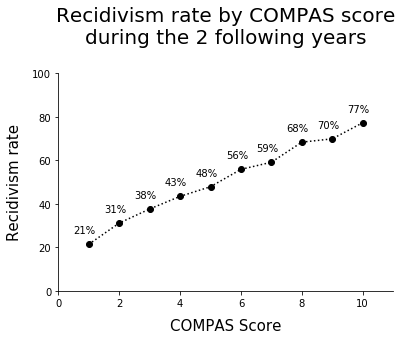

In [21]:
plot_recidivism_by_decile_score()

> On the graph above, the number of people who reoffend mainly increases in function of the `COMPAS` _score_. This first observation shows us that the _scores_ are meaningful, and that they almost describe in a linear way the odds that the person reoffend.

Now we would like to have the same representation but by `COMPAS` _risk category_:

In [22]:
def plot_recidivism_by_risk_cat():
    """
    Plot the recidivism rate by COMPAS risk category.
    """
    # Plot.
    to_plot = df.two_year_recid.groupby(df.score_text).mean()\
                .sort_values() * 100
    ax = to_plot.plot(style = "ok", linestyle = "dotted")
    # Value beside each dot.
    for i, v in enumerate(to_plot):
        ax.text(i, v + 5, "%.0f" %v + "%")
    # Size.
    plt.xlim(-1, 3)
    plt.ylim(0, 100)
    # Set labels + despine.
    utils.plt_decorate(ax, 
                       "Recidivism rate by COMPAS risk category\n" 
                       + "during the 2 following years",
                       "COMPAS Score category", 
                       "Recidivism rate")

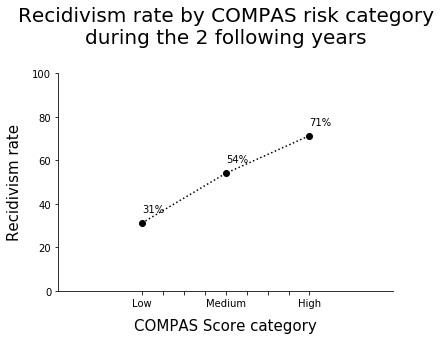

In [23]:
plot_recidivism_by_risk_cat()

> Again, the graph represents a notable increase in the rate is observed between each of these categories.

Thus, from what we observed, the `COMPAS` measurements seem to be meaningful. They represent the increase of the recidivism in an almost linear way. 
<br>
However our representations doesn't compute the accuracy of the model.

### 2.3.4. Overall accuracy

Now that we are convinced that the `COMPAS` model outputs meaningful information, we would like to compute the accuracy of the model.
<br>
To do this, we must classify the `COMPAS` _output_ (_i.e. the decile score or the risk category_) into two classes. This will allow us to compute the _true positives_, _true negatives_, _false positives_ and _false negatives_ output by the `COMPAS` model, and so the accuracy for the whole dataset.
<br>
In both cases (_decile scores_ or _risk categories_), this means that we should apply a threshold between the `COMPAS` _scores_ (since the _risk categories_ are defined by the _decile scores_). 
<br>
<br>
For example, as `ProPublica`, we could use the following threshold: we consider `low-risk` individuals as negative classifications, `medium` and `high-risk` as positive ones (so a threshold sets at `COMPAS` _score_ = 4).
Nevertheless, as stated in a 2019 study **[2]**, "This grouping of medium and highrisk, notably, has received pushback from the designers of the COMPAS algorithm".
<br>
<br>
Thus, to find the best threshold (the one which provides the best _accuracy_), we decide to use a `Logistic Regression` model on the data. The model is the following one; the dependent variable is `two_year_recid`, and the independent one is `decile_score`. 
<br>
Thus, the _regression_ will try to classify people into 2 classes using the best threshold to try to predict `two_year_recid_` (_i.e. the person will reoffend or not_), using only their `COMPAS` _score_.
<br>
<br>
We decide to train our _regression_ on the whole dataset, to find the threshold that represent the better our dataset without any bias (we are not interested in predicting here, we just want to find a threshold for our whole study, and use it to do our calculations).

In [24]:
def train_logistic_regression(model, df_):
    """
    Train (fiting) the logistic regession "model" on 
    the whole dataset "df_".
    We doesn't use the 'train_test_split' function because we train 
    on the whole dataset to find the best threshold without any bias.
    """   
    X = df_.decile_score[:, np.newaxis]
    y_true = df.two_year_recid
    model.fit(X, y_true)
    
    
def test_logistic_regression(model, X):
    """
    Test (predict) the logitic regression "model" on the feature "X", 
    and return the predictions.
    """
    X = X[:, np.newaxis]
    return model.predict(X)
    
        
def display_predictions(X, y_pred):
    """
    Display the predictions on the COMPAS scores.
    """
    fig, ax = plt.subplots(figsize = (8, 4))
    _ = ax.scatter(X, y_pred, color = ["red" if x else "green" for x in y_pred])
    # Decoration.
    utils.plt_decorate(ax, 
                       "The \"will reoffend\" predictions in function of\n"
                       + "the COMPAS score on the whole dataset",
                       "COMPAS score", 
                       "Will reoffend")
    locs, labels = ax.set_yticks([0, 1], ["False", "True"])
       
    
def display_confusion_matrix(y_true, y_pred, title = "", ax = None):
    """
    Display the wanted results (confusion matrix, accuracy or threshold).
    """
    if ax is None:
        fig, ax = plt.subplots(figsize = (8, 4))
    # Plot.
    M = skmetrics.confusion_matrix(y_true, y_pred)
    disp = skmetrics.ConfusionMatrixDisplay(
        confusion_matrix = M, 
        display_labels = ["will not", "will"])
    _ = disp.plot(ax = ax)
    # Decoration.
    utils.plt_decorate(ax, 
                       "Confusion matrix (will reoffend,\nor will not) " 
                       + title, 
                       "Predicted Label", 
                       "True Label",
                       despine = False)  
    
    
def display_accuracy(y_trues, y_preds, row, col, message = ""):
    """
    Display the accuracy of the predictions on the given results.
    """
    fig, ax = plt.subplots(figsize = (12, 8))
    ax.axis('off')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())    
    # Load data to plot.
    accuracies = [skmetrics.accuracy_score(y_true, y_pred) 
                  for (y_true, y_pred) in zip(y_trues, y_preds)] 
    # Plot it.
    table = ax.table(cellText = [accuracies],
             rowLabels = row,
             colLabels = col,
             rowColours = ["orange" for i in accuracies],
             colColours = ["orange" for i in accuracies],
             colWidths = [0.05 for i in accuracies],
             cellLoc = "center",
             loc = "center")
    table.set_fontsize(15)
    table.scale(5, 5)

As we said, we train our model on the whole dataset, before testing it with the whole dataset again:

In [25]:
model = sklinear.LogisticRegression(fit_intercept = True)
train_logistic_regression(model, df)
y_pred_COMPAS = test_logistic_regression(model, df.decile_score)

Then we display the threshold:

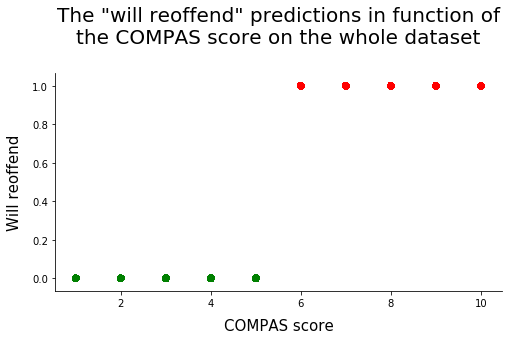

In [26]:
display_predictions(df.decile_score, y_pred_COMPAS)

> As the graphs shows, the _regression_ sets the threshold at `COMPAS` _score_ = 5 (_i.e. the red scores in [6, 10] are judged as "will reoffend"_).

Now we display the _confusion matrix_:

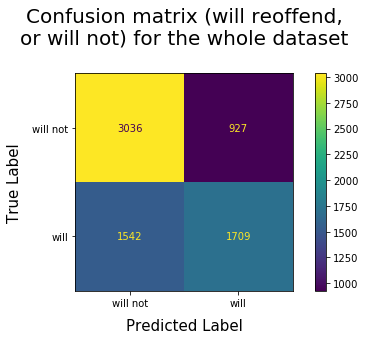

In [27]:
display_confusion_matrix(df.two_year_recid, y_pred_COMPAS, 
                         title = "for the whole dataset")

> We remark that the `COMPAS` _score_ is better at predicting people who will not reoffend.But this could be explained; in fact, 2 times more people are predicting as _"will not"_. Also, we have seen that almost 1 in 2 people of our dataset get re-arrested, however as we said $\frac{2}{3}$ of the predictions are for _"will not"_.
<br>
On the other hand, logically, the predictions for ones "who will" are less.
<br>
Also, we remark that for both positives and negatives predictions, $\frac{1}{3}$ of them are false.

Then finally we display the _accuracy_:

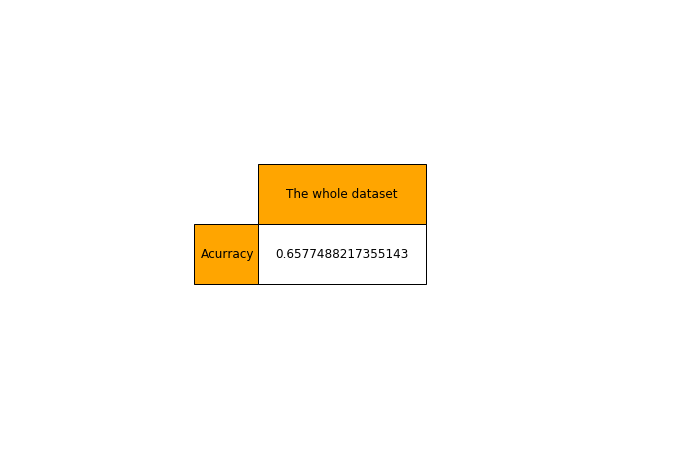

In [28]:
display_accuracy([df.two_year_recid], [y_pred_COMPAS], 
                 row = ["Acurracy"],
                 col = ["The whole dataset"])

> The _accuracy_ fits the previous observations: ~ $\frac{1}{3}$ of the predictions are false.

### 2.3.5. False positives, negatives, and biases

After seeing the _accuracy_ for the whole dataset, we would like to check it for different races and genders:

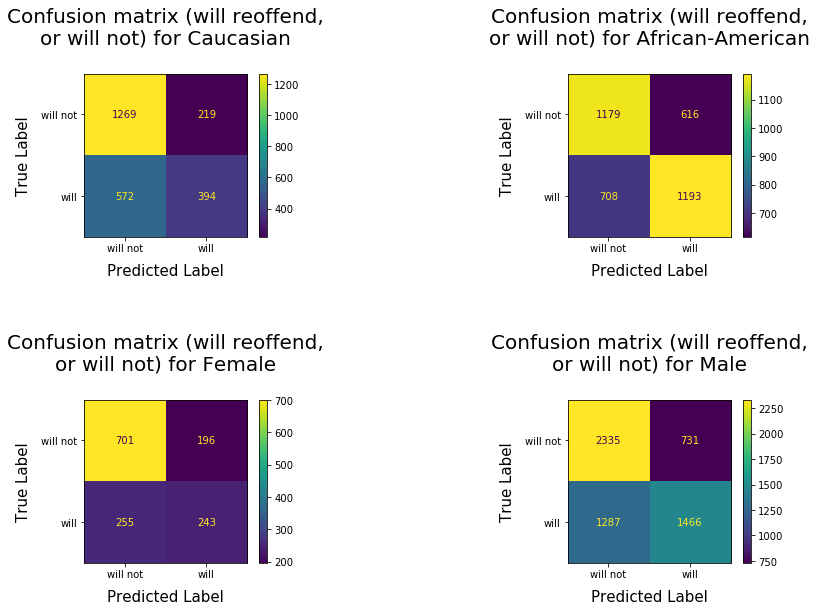

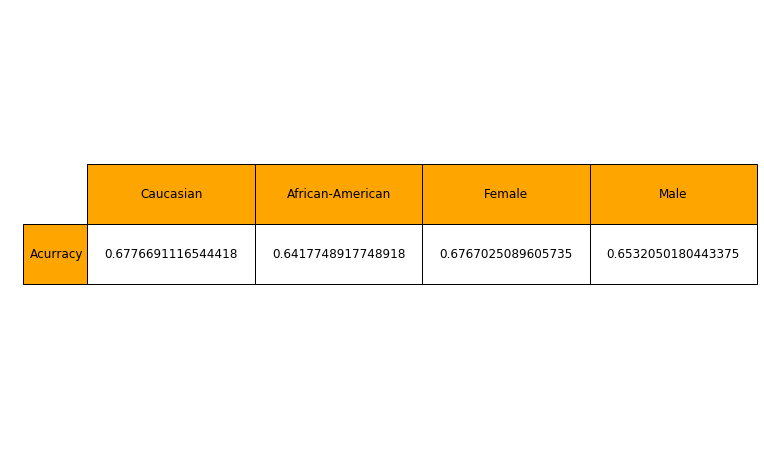

In [29]:
y_trues = []
y_preds = []
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize = (13, 9))
fig.subplots_adjust(wspace = 1, hspace = 1)

# Test on races.
for race in ["Caucasian", "African-American"]:
    # Select data.
    to_test = df[df.race == race]
    # Make predictions.
    y_trues.append(to_test.two_year_recid)
    y_preds.append(test_logistic_regression(model, to_test.decile_score))
    # Display confusion matrix.
    display_confusion_matrix(y_trues[-1], y_preds[-1], 
                             title = "for " + race,
                             ax = ax0 if race == "Caucasian" else ax1)
# Test on genders.
for sex in ["Female", "Male"]:
    # Select data.
    to_test = df[df.sex == sex]
    # Make predictions.
    y_trues.append(to_test.two_year_recid)
    y_preds.append(test_logistic_regression(model, to_test.decile_score))
    # Display confusion matrix.
    display_confusion_matrix(y_trues[-1], y_preds[-1], 
                         title = "for " + sex,
                         ax = ax2 if sex == "Female" else ax3)
# Display the accuracy for each one of the prior tests.
display_accuracy(y_trues, y_preds, 
                 row = ["Acurracy"],
                 col = ["Caucasian", "African-American", "Female", "Male"])

> We see that the _accuracy_ for both `African-Americans` and `Males` is a bit below the average with something around 65%.
On the other hand for the `Females` and `Caucasians`, the _accuracy_ is bit above the average with 68%.
So, nothing alarming here, the differences are small.
<br>
<br>
Nevertheless, if we take a look at the mistakes made by `COMPAS` we see some important information:
>    * About the _false positives_ rate (who did not recidivate and are incorrectly predicted):
>        * `African-Americans`: $\frac{616}{(616 + 1179)} =$ 34%.
>        * `Caucasians`: $\frac{219}{(219 + 1269)} =$ 15%.
>        * `Females`: $\frac{196}{(196 + 701)} =$ 22%.
>        * `Males`: $\frac{731}{(731 + 2335)} =$ 24%.
>        * For the whole data set: $\frac{927}{(927 + 3096)} =$ 23%.
>    * About the _false negatives_ rate (who did recidivate and are incorrectly predicted):
>        * `African-Americans`: $\frac{708}{(708 + 1193)} =$ 37%.
>        * `Caucasians`: $\frac{572}{(572 + 394)} =$ 59%.
>        * `Females`: $\frac{255}{(255 + 243)} =$ 51%%.
>        * `Males`: $\frac{1287}{(1287 + 1466)} =$ 47%%.
>        * For the whole data set: $\frac{1542}{(1542 + 1709)} =$ 47%.
>    * About the _positive_ predictions (_"will recidivate"_) in general:
>        * `African-Americans` are predicted _positive_ at 49%.
>        * `Caucasians` are predicted _positive_ at 25%.
>        * `Females` are predicted _positive_ at 31%.
>        * `Males` are predicted _positive_ at 38%.
>        * For the whole data set it is 37%.

> Thus, the `COMPAS` _scores_ seem to give an advantage to the `Caucasians`; they underpredict recidivism among them, and overpredict it among the `African-Americans`. 
> On the other hand, these _scores_ may give an advantage to the `Females` which may be "underestimated"; they seem to be a little bit underpredicted, however, the difference is too small to be taken in account.

## 2.4. Conclusion

As we have see, the `African-Americans` are more likely to be misclassified as a higher risk of recidivism, their `COMPAS` _scores_ are overestimated; twice as much as the `Caucasians`. On the other hand, the `Caucasians` ones are more likely to be underestimated; 22% more than the _scores_ of the `African-Americans`. In a general way, `African-Americans` are predicted _positive_ twice as much as the `Caucasians`.
<br>
Also, in comparison with the whole data set, `African-Americans` have lower false negative rates, and higher false positive rates, while the `Caucasian` are at the opposite. This is not surprising since the software seems to give a higher _score_ to the first race (positive at 49%), and a lower one to the other one (positive at 25%).
<br>
<br>
The difference of the _scores_ between `Females` and `Males` is too slight. So, it seems that the _classifier_ is "fair" about it. Nevertheless, the size of the `Females` sample is really small, and it can be not representative.
<br>
<br>
Also, we should keep in mind that the `COMPAS` _scores_ are not directly predicting exactly that someone is going to recidivate or not. We had to map these _scores_, thanks to a threshold, to a _boolean_ prediction (_will recidivate or not_). Furthermore, the size of our dataset was limited and it could include unique bias to itself. Just like the size of the _races_ and _genders_ which were compared; they don't have the same size at all.
<br>
However the differences between `Caucasians` and `African-Americans` are very significant.
<br>
To finish, from the previous conclusions, at first glance, the `COMPAS` model is not fair. We may also note that if it was trained with biased data like these ones, it would explain why the software probably produces biased results.
<br>
<br>
**Remark**: as detailed before, since we are not using the same _threshold_ as `ProPublica`, our biases are represented with different rates than in their study, but are represented in the same way.

# <b>3. Standard classifiers</b>

In this part we are going to train some classifiers to try to predict who will recidivate, and we will analyze the importance of some of the predictor variables. Then we are going to take a look at the results to analyze their performance, and whether they are more or less fair than the COMPAS classifier.

## 3.1. Preparing the work plan

### 3.1.1. Independent variables selection

The aim of our selection is to reduce the set of predictor variables to those that are necessary. We need to determine the level of importance of each predictor variable.
<br>
According to our lack of knowledge in choosing these, we choose to do a _forward selection_ based on our intuition. Thus the first variable is the one that seems the most important for us, and the last the least important:

1. `prior_count`: the number of prior (non-juvenile) crimes.
2. `c_charge_degree`: the degree of the charge.
3. `juv_fel_count`: the number of prior juvenile felonies.
4. `juv_misd_count`: the number of prior juvenile misdemeanors. 
5. `juv_other_count`: the number of prior juvenile convictions that are not considered either felonies or misdemeanors.
6. `age`: the age of the defendant.
7. `sex`: the sex of the defendant.
8. `race`: the race of the defendant. 

The variables _3, 4, 5, and 8_ are special; we will train and test the classifiers with and without it.

### 3.1.2. Data preparation

First we create three _datasets_, one with all the features, another without the `race` and a last one without the `race` and the `juvenile` information:

In [30]:
# All features.
df_all = df[["two_year_recid", "priors_count", "c_charge_degree", 
                "juv_fel_count", "juv_misd_count", "juv_other_count",
                "age", "sex", "race"]]
# Without races.
df_wo_race = df[["two_year_recid", "priors_count", "c_charge_degree",
                 "juv_fel_count", "juv_misd_count", "juv_other_count",
                 "age", "sex"]]
# Without races and juvenile information.
df_wo_race_juv = df[["two_year_recid", "priors_count", "c_charge_degree",
                 "age", "sex"]]

Then, we need to prepare the variables to be processed by the classifiers. To do this, we _factorize_ each _non-numeric_ of them:

In [31]:
def factorize(df_, columns):
    """
    Factorize the given columns.
    """
    for column in columns:
        df_[column] = pd.factorize(df_[column])[0]

In [32]:
factorize(df_all, ["sex", "c_charge_degree", "race"])
factorize(df_wo_race, ["sex", "c_charge_degree"])
factorize(df_wo_race_juv, ["sex", "c_charge_degree"])

<ipython-input-31-39317183a8c1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_[column] = pd.factorize(df_[column])[0]


### 3.1.3. Routines

Finally, we define some methods that we will use when examining the predictions of each classifier. To show the results we will also use some _"display"_ functions of the previous part.

In [33]:
def routine(fun, df_, message = ""):
    """
    The main function called for each classifier. Train and 
    predict on "df_" with "fun" (the classifier), then display 
    the results.
    Also return the predicted values with their labels.
    """
    # Prepare plot.
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (14, 3))
    fig.subplots_adjust(wspace = 0.5)
    # Predict with the model.
    y_true, y_pred = fun(df_)
    # Display.
    display_true_vs_pred(y_true, y_pred, message, ax = ax0)
    display_confusion_matrix(y_true, y_pred, message, ax = ax1)
    return y_true, y_pred
    
    
def display_true_vs_pred(y_true, y_pred, message = "", ax = None):
    """
    Display the histogram of the orignal values and predictions
    of the classifier.
    """
    _ = ax.hist([y_true, y_pred], 
                 label = ["test values", "predicted values"],
                 bins = 4,
                 color = ["green", "darkred"],
                 rwidth = 1)
    # Decoration.
    utils.plt_decorate(ax,
                      "Distribution of the predictions\n " + message,
                      "Values (0 = will not reoffed, 1 = will)", 
                      "Total People")
    ax.legend(loc = "upper right")
    
    ax.set_xlim(-1, 2)
    ax.set_xticks([0, 1])

Thus, we are ready for our first classifications.

## 3.2. Logistic regression

Our first classifier will be a `Logistic regression`:

In [34]:
def do_logistic_regression(df_):
    """
    Train (fiting) and test (predict) a logistic regession "model" 
    on "df_". Return the labels, and predicted values.
    """
    model = sklinear.LogisticRegression(fit_intercept = True)
    # Get data.
    X = df_.drop("two_year_recid", axis = 1)
    y = df_.two_year_recid
    # Train and predict.
    X_train, X_test, y_train, y_test = skselect.train_test_split(X, y, 
                                                        random_state = RANDOM_STATE,
                                                        train_size = 0.8)
    model.fit(X_train, y_train)
    return y_test, model.predict(X_test) 

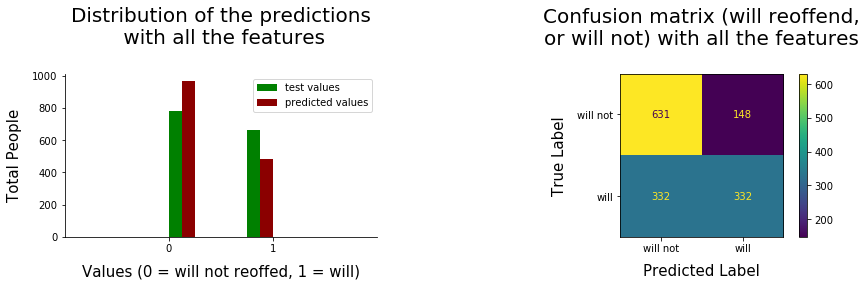

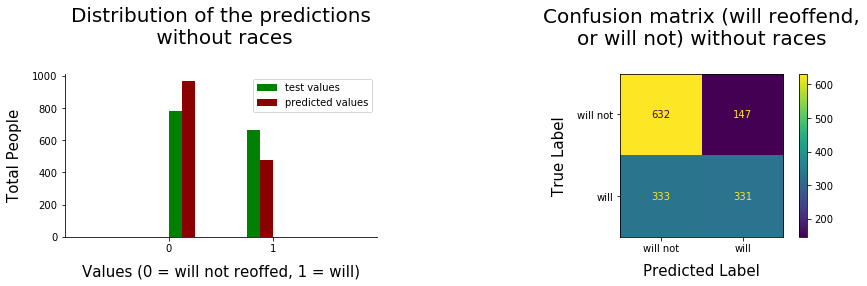

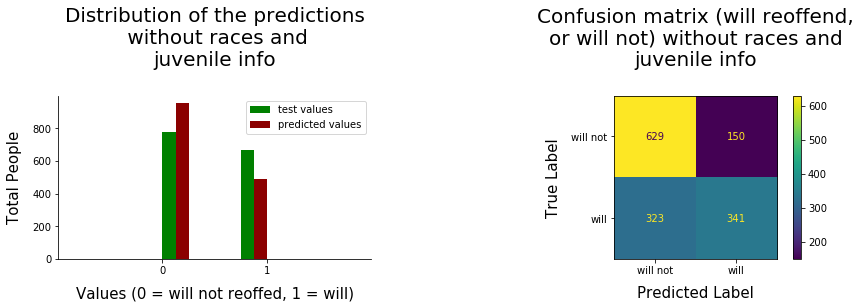

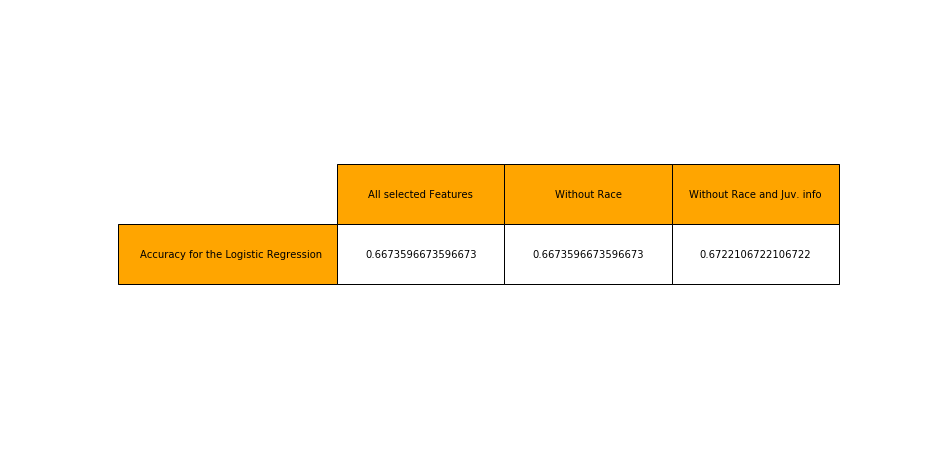

In [35]:
# Execute the routine on all the datasets.
y_true_1, y_pred_1 = routine(do_logistic_regression, 
                             df_all, 
                             "with all the features")
y_true_2, y_pred_2 = routine(do_logistic_regression, 
                             df_wo_race, 
                             "without races")
y_true_3, y_pred_3 = routine(do_logistic_regression, 
                             df_wo_race_juv, 
                             "without races and\njuvenile info")
# Also store the results to compare them after.
lr_true = [y_true_1, y_true_2, y_true_3]
lr_pred = [y_pred_1, y_pred_2, y_pred_3]
# Display the accuracy for each dataset.
display_accuracy(lr_true, lr_pred, 
                 row = ["Accuracy for the Logistic Regression"],
                 col = ["All selected Features", "Without Race", 
                        "Without Race and Juv. info"])

> The accuracy is exactly the same with and without the `race` feature, and when we also remove juvenile information, the accuracy slightly increases.
<br>
Nevertheless, the results are mainly the same as the ones of the `COMPAS` analysis. The rate of _false negatives_ is always around 0.5 and the _false positives_ rate is located just below this value, around 0.2.

## 3.3. Random forest

After testing _linear classifiers_, we would like to test a first _non-linear_ model. To do this, we decide to use a `Random Forest` classifier:

In [36]:
def do_random_forest(df_, trees = 100):
    """
    Train (fiting) and test (predict) a random forest "model" 
    on "df_". Return the labels, and predicted values.
    """
    model = skensemble.RandomForestClassifier(n_estimators = trees)
    # Get data.
    X = df_.drop("two_year_recid", axis = 1)
    y = df_.two_year_recid
    # Train and predict.
    X_train, X_test, y_train, y_test = skselect.train_test_split(X, y, 
                                                        random_state = RANDOM_STATE,
                                                        train_size = 0.8)
    model.fit(X_train, y_train)
    return y_test, model.predict(X_test) 

First we evaluate the number of _trees_ needed in the _"forest"_ to be as accurate as possible, depending on the execution time (_i.e. the number of trees mainly_):

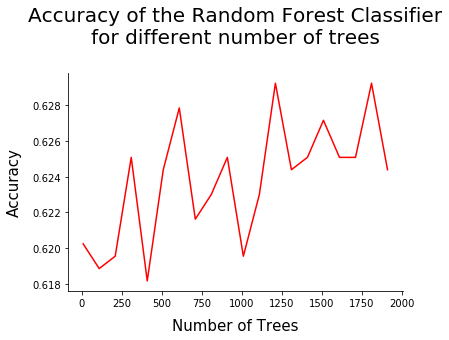

In [37]:
accuracy = []
X = range(10, 2010, 100)

for i in X:
    # Only on the "all features" dataset.
    y_true, y_pred = do_random_forest(df_all, trees = i)
    accuracy.append(skmetrics.accuracy_score(y_true, y_pred))

ax = plt.subplot()
_ = ax.plot(X, accuracy, color = "red")
utils.plt_decorate(ax,
               "Accuracy of the Random Forest Classifier\n"
               + "for different number of trees",
               "Number of Trees",
               "Accuracy")

As we can see, the accuracy is random, and since each execution depends on random parameters, even with the same number of _trees_, the results are never the same. Thus, we set the number of _trees_ to 100 to have a short execution time.

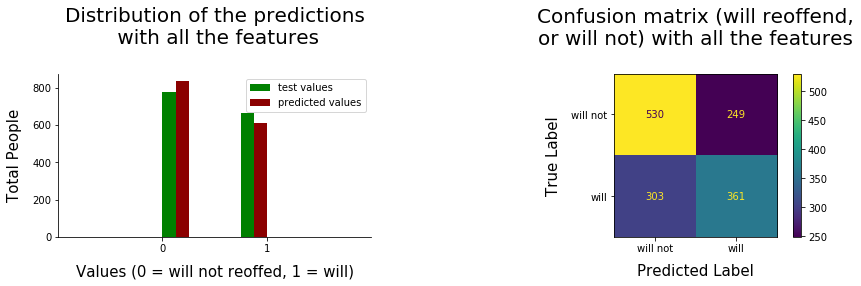

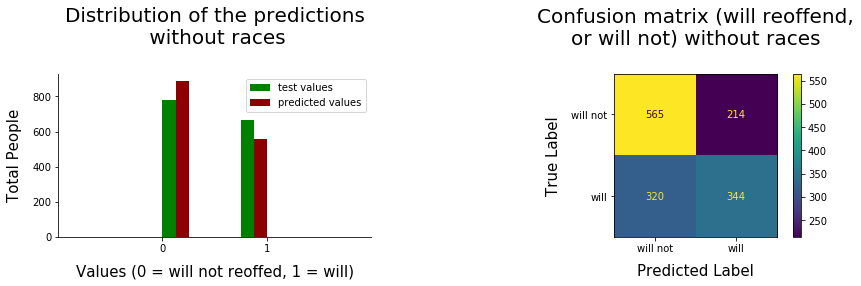

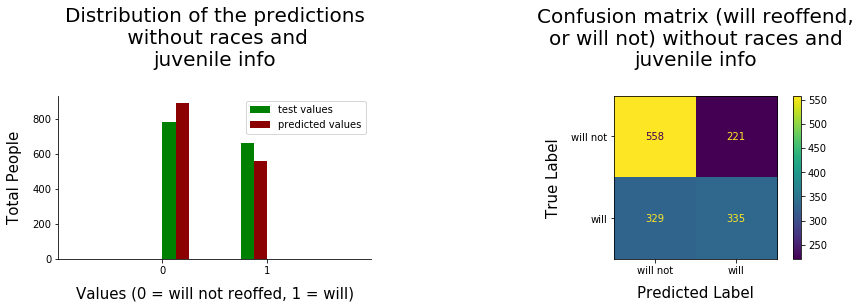

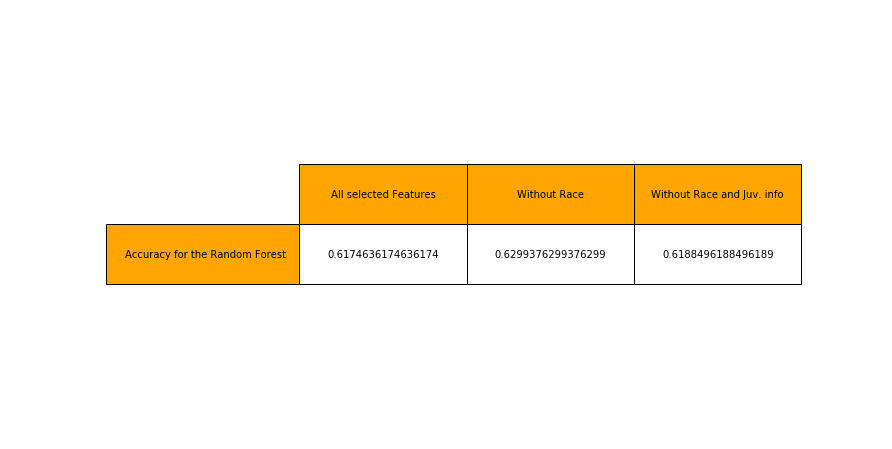

In [38]:
# Execute the routine on all the datasets.
y_true_1, y_pred_1 = routine(do_random_forest, 
                             df_all, 
                             "with all the features")
y_true_2, y_pred_2 = routine(do_random_forest, 
                             df_wo_race, 
                             "without races")
y_true_3, y_pred_3 = routine(do_random_forest, 
                             df_wo_race_juv, 
                             "without races and\njuvenile info")
# Also store the results to compare them after.
rf_true = [y_true_1, y_true_2, y_true_3]
rf_pred = [y_pred_1, y_pred_2, y_pred_3]
# Display the accuracy for each dataset.
display_accuracy(rf_true, rf_pred,
                 row = ["Accuracy for the Random Forest"],
                 col = ["All selected Features", "Without Race", 
                        "Without Race and Juv. info"])

> Even if it uses a _non-linear hyperplane_, our _model_ seems to be less accurate than the previous one. However we notice a slight difference when removing some features of the dataset.
Indeed, without the `race` feature, our model seems to be more efficient. But it is only a slight difference, and we should keep in mind that at each execution, and for different _number of trees_ the accuracy of our model can radically change (_e.g. 100 trees can be less accurate than 99 trees for example, and results can be totally different, as we have seen with our previous "convergence" plot_).
<br>
The number of _false predictions_ is the almost the same as the ones of the `Logistic Regression`. Overall _false negatives_ have a rate around 0.5 and _false positives_ one around 0.3.

## 3.4. Support Vector Machine

Now, we would like to try classification with a different _non-linear hyperplane_. Thus, we choose to test it using a _SVM classifier_:

In [39]:
def do_svm(df_, kernel = "rbf"):
    """
    Train (fiting) and test (predict) a SVC "model" 
    on "df_". Return the labels, and predicted values.
    """
    model = sksvm.SVC(kernel = kernel)
    # Get data.
    X = df_.drop("two_year_recid", axis = 1)
    y = df_.two_year_recid
    # Train and predict.
    X_train, X_test, y_train, y_test = skselect.train_test_split(X, y, 
                                                        random_state = RANDOM_STATE,
                                                        train_size = 0.8)
    model.fit(X_train, y_train)
    return y_test, model.predict(X_test) 

First we need to select a _kernel_ function. To do this, we tested multiple configuration for our `SVC` model. 

* _Polynomial_ kernel tends to classify almost everyone  in the _"will not recidivate"_ box no matters the _degree_ of the _polynomial_.
* _Sigmoid_ and _linear_ kernels have no interest.
* _Radial basis function (RBF)_ seems to be the best kernel since it gives us the best results, and is non-linear.

Thus, the following results are made using a _RBF_ kernel:

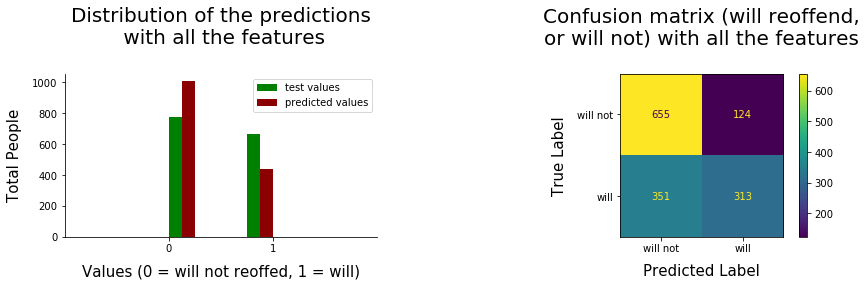

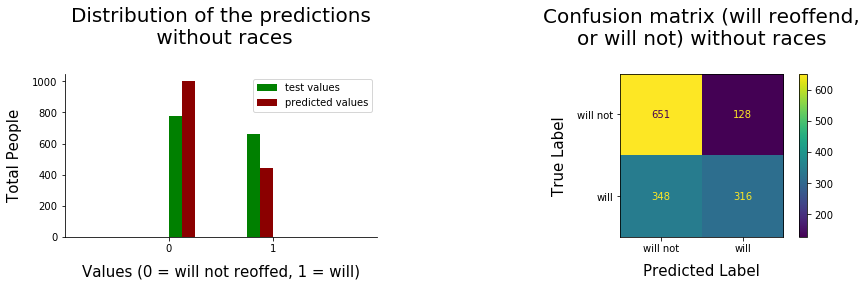

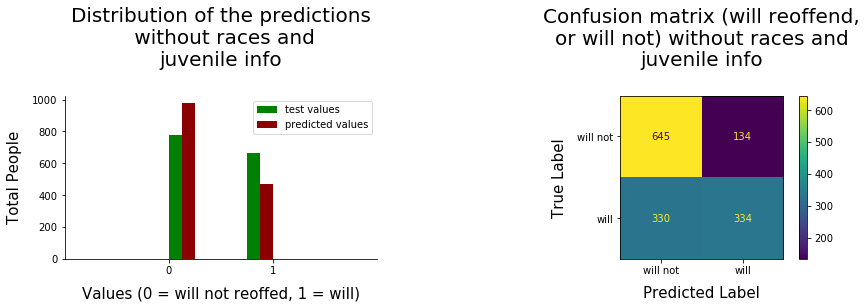

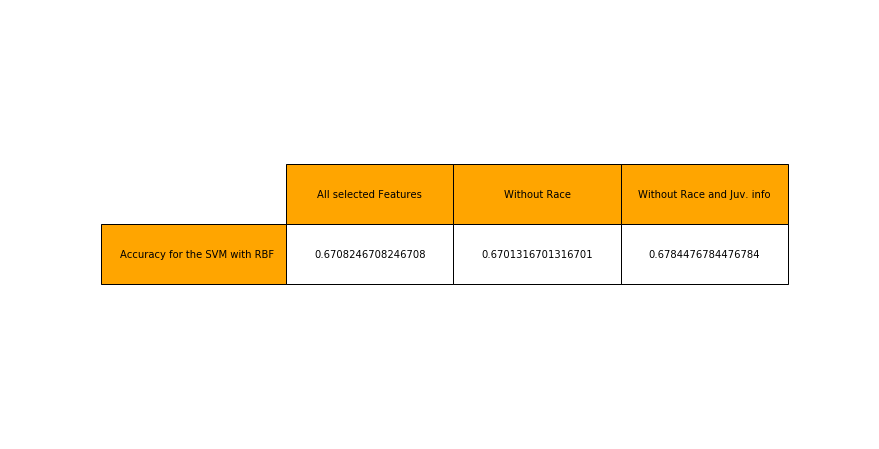

In [40]:
# Execute the routine on all the datasets.
y_true_1, y_pred_1 = routine(do_svm, 
                             df_all, 
                             "with all the features")
y_true_2, y_pred_2 = routine(do_svm, 
                             df_wo_race, 
                             "without races")
y_true_3, y_pred_3 = routine(do_svm, 
                             df_wo_race_juv, 
                             "without races and\njuvenile info")
# Also store the results to compare them after.
svm_true = [y_true_1, y_true_2, y_true_3]
svm_pred = [y_pred_1, y_pred_2, y_pred_3]
# Display the accuracy for each dataset.
display_accuracy(svm_true, svm_pred, 
                 row = ["Accuracy for the SVM with RBF"],
                 col = ["All selected Features", "Without Race", 
                        "Without Race and Juv. info"])

> This model is more efficient than the prior ones as we can see with the _accuracy_. Here we see a slight improvement when removing `race` and `juvenile` _information_ at the same time, but again it's not something noticeable that needs to be recorded. 
<br>
As with the previous _classifiers_, _false negatives_ rate is around 0.5, nevertheless, _false positives_ rate is better; with the 3 datasets, the rate is below 0.2 (around 0.17).

## 3.5. Comparisons

Now we would like to process all the information from the previous _classifiers_ at the same time, and compare them.

### 3.5.1. ROC curve

For each one of our classifiers, we display it's `ROC` curve:

In [41]:
def display_roc_curves():
    """
    Display the ROC curve of all the classifiers.
    """
    fig, ax = plt.subplots(figsize = (12, 8))
    # Plot classifiers.
    display_roc_curve(ax, lr_true, lr_pred, 
                      color = "green", 
                      name = "Logistic Regression",
                      linestyle = "dashdot")
    display_roc_curve(ax, rf_true, rf_pred, 
                      color = "blue", 
                      name = "Random Forest",
                      linestyle = "dotted")
    display_roc_curve(ax, svm_true, svm_pred, 
                      color = "orange", 
                      name = "SVM with RBF",
                      linestyle = "dashed")
    display_roc_curve(ax, [[0, 1]], [[0, 1]], 
                      color = "grey", 
                      name = "Perfect Classifier",
                      linestyle = "solid",
                      linewidth = 0.5)
    display_roc_curve(ax, [[0, 0, 1, 1]], [[1, 0, 1, 0]], 
                      color = "black", 
                      name = "Random Classifier",
                      linestyle = "solid",
                      linewidth = 0.5)
    display_roc_curve(ax, [df.two_year_recid], [y_pred_COMPAS], 
                      color = "red", 
                      name = "COMPAS",
                      linestyle = "solid",
                      linewidth = 2)
    # Decorate.
    _ = ax.legend(loc = "lower right", prop = {'size': 15})
    utils.plt_decorate(ax, 
                       "ROC curves for classification on the 3 datasets\nusing our models", 
                       "False Positives rate", "True Positives rate")

    
def display_roc_curve(ax, y_trues, y_preds, color = "red", 
                     name = "", linestyle = "solid",
                     linewidth = 2):
    """
    Display the ROC curve of the given classifier, with the
    given style.
    """
    labelled = False
    
    for (y_true, y_pred) in zip(y_trues, y_preds):
        fpr, tpr, _ = skmetrics.roc_curve(y_true, y_pred)
        _ = ax.plot(fpr, tpr, 
                    linewidth = linewidth,
                    linestyle = linestyle, 
                    color = color,
                    label = name if not labelled else None)
        labelled = True

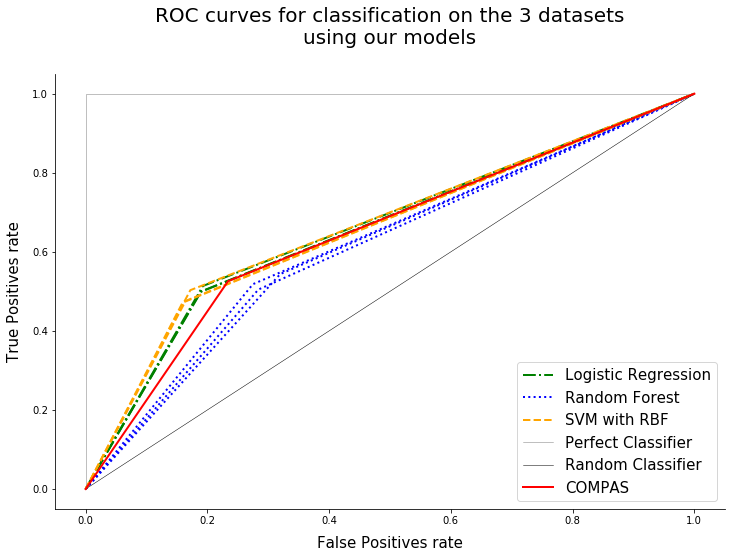

In [42]:
display_roc_curves()

> Since we are working on _discrete_ values (binary decision), we only get 3 points per curve ((0,0), the (_fpr_,_tpr_) and (1,1)). For each classifier, the curve is almost the same for the different datasets. However we can see that `SVM` seems to be slightly better, as we have seen when computing false predictions rate before; it has a the lowest rates.

### 3.5.2. AUC comparisons

We display the `AUC` for each one of our classifiers:

In [43]:
def display_auc_values():
    """
    Display the AUC of all the classifiers.
    """
    fig, ax = plt.subplots(figsize = (12, 8))
    ax.axis('off')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())    
    # Load data to plot.
    scores = []
    # - Classifiers:
    scores.append(get_auc_values(lr_true, lr_pred))
    scores.append(get_auc_values(rf_true, rf_pred))
    scores.append(get_auc_values(svm_true, svm_pred))
    for s in scores:
        s.insert(0, "None")
    # - COMPAS:
    scores.append(get_auc_values([df.two_year_recid], [y_pred_COMPAS]))
    scores[-1].append("None")
    scores[-1].append("None")
    scores[-1].append("None")
    # Plot classifiers.
    table = ax.table(cellText = scores, 
             rowLabels = ["Logistic Regression", "Random Forest", 
                          "SVM with RBF", "COMPAS"],
             colLabels = ["Original Dataset", "All selected Features", 
                          "Without Race", "Without Race and Juv. info"],
             rowColours = ["orange" for i in scores],
             colColours = ["orange" for i in scores],
             colWidths = [0.05 for i in scores],
             cellLoc = "center",
             loc = "center")
    table.set_fontsize(15)
    table.scale(5, 5)
                  
                  
def get_auc_values(y_trues, y_preds):
    """
    Compute the AUC of the given classifier values and return it.
    """
    scores = []
                  
    for (y_true, y_pred) in zip(y_trues, y_preds):
        scores.append(skmetrics.roc_auc_score(y_true, y_pred))
                  
    return scores

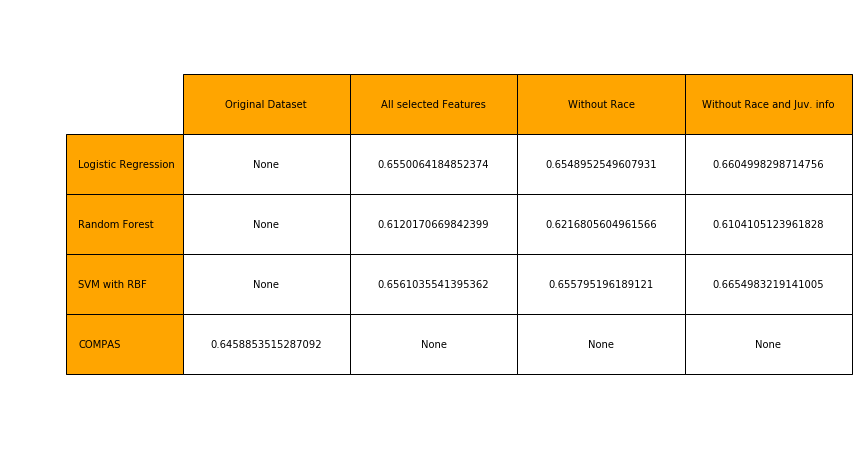

In [44]:
display_auc_values()

> The best accuracy obtained is without the race and juvenile information, and using the `SVM` classifier. The worst ones are obtained with the `Random Forest`; they are even under the one given by the `COMPAS` classifier. Otherwise, every accuracy is higher than the `COMPAS` one.

## 3.6. Limits

There are multiple ways of training and testing classifiers on the `COMPAS` dataset.
<br>
We selected only 3 datasets, based on our judgment and intuition. Nevertheless, it exist $2^{137} - 1$ ways of creating them, and features selection is very important.
<br>
We selected 3 classifiers, however it exists a lot of classifiers, and also a lot of way to configure their parameters.
<br>
Also, we could have made a _cross-validation_ to check in details veracity of the results.

It also seems that with the given attributes, we cannot draw a linear or curved line to correctly separate them. For example, even with a dataset of two attributes ("sex" and "age"), we can clearly imagine that we cannot find a hyperplane to separate the "will recidivate" and "will not" values even in a more than a 2-dimensions space:

In [45]:
def scatter_sex_age():
    fig, ax = plt.subplots(figsize = (12, 8))

    colors = df.two_year_recid.apply(lambda x: 'red' if x else 'green')
    # We add some noise at the sex attribute to clearly distinguish the points.
    _ = plt.scatter(pd.factorize(df.sex)[0] + np.random.normal(-0.05, 0.05, len(df.sex)), 
                    df.age, 
                    c = colors, 
                    alpha = 0.1)
    utils.plt_decorate(ax, 
                       "Recidivate values (in red if true otherwise green)\n"
                       + "depending on age and sex", 
                       "Males                |                 Females", 
                       "Age")

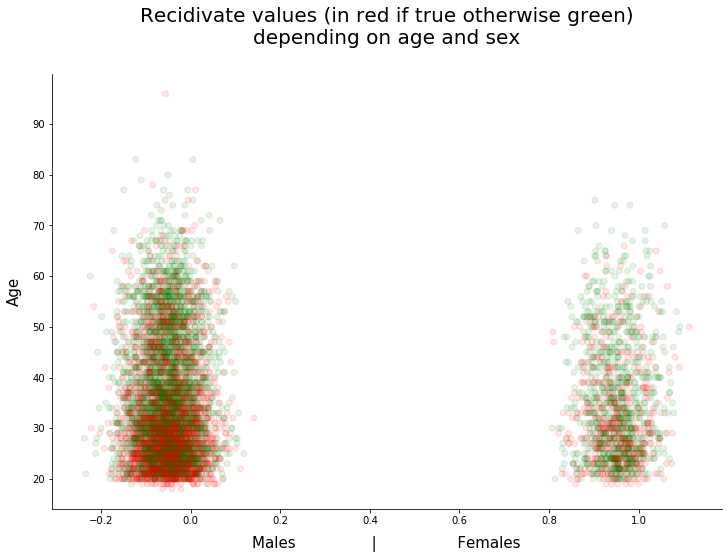

In [46]:
scatter_sex_age()

## 3.7. Conclusion

As we have seen, most of our _classifiers_ are slightly better than the `COMPAS` one. Nevertheless, the difference is not significant, and it can be possible that with different testing datasets, the results could be worse or better (and same for the `COMPAS`).
<br>
We have also created a "worse" _non-linear_ classifier; a `Random Forest`.
<br>
Overall, even with a _non-linear hyperplane_, we cannot create a "good" classifier. Indeed, there is no way to find a hyperplane that separates the "will recidivate" and "will not"_ in a proper way, even in a curved plane or else.

# <b>4. Fair classifier</b>

Since we know that machines can take decisions influencing society, we should be careful about how we define classifiers, even more for a field like justice. Fairness has to be the main priority for those kind of classifiers and they have to separate individual traits that are not correlated with recidivism.

And `COMPAS` do not derogate from the rule; as required by law, it does not include race in calculating risk scores. Nevertheless, our study showed that the `COMPAS` score includes biases against `African-American` defendants.

## 4.1. Our definition of fairness

Fairness has multiple definitions, especially in machine learning. However, in classification problems, fairness criterias have been defined.

There are many definitions of fairness that have been proposed in the literature **[3]**. The 3 following laws fall into a larger category called "group fairness":

* **Law 1: Independence** (also called demographic parity; the probability of being classified by the algorithm in each of the groups is equal for two individuals with different sensitive characteristics).
* **Law 2: Separation** (also called predictive value parity; the probability of being classified by the algorithm in each of the groups is equal for two individuals with different sensitive characteristics given that they actually belong in the same group)
* **Law 3: Sufficiency** (also called equalized odds; the probability of actually being in each of the groups is equal for two individuals with different sensitive characteristics given that they were predicted to belong to the same group).

With these laws, come some properties/relationships:

* Either **separation** or **sufficiency** holds, but not both.
* Either **independence** or **separation** holds, but not both.
* Either **independence** or **sufficiency** holds, but not both.

Therefore we can only satisfy one of these laws at a time.

So, we could build a classifier which tries to respect the **separation** law. However, as we have seen before, separating attributes using a hyperplane, so that it clearly separate the _will reoffend_ and _will not_ labels, seems to be impossible, and will not be accurate enough.

We could also build a classifier which tries to respect the **sufficiency** law. Nevertheless, it requires consistency of positive/negative predictive values across all groups, and this may be hard to achieve.

Building a classifier which tries to respect the **independence** law is possible and may be the easier to realize; we have to create a dataset which does not contain _sensitive attributes_, such that each person, no matter her/his _sensitive attributes_, have the same chances as any other person.

## 4.2. Selecting the dataset

From the previous part, we know that the `Race` attribute is a sensitive one. We also know that the `Sex` and `Age` attributes are demographic ones, and may be sensitive too.

Also, as we know, **demographic parity** requires the outcome to be independent of the classes. In our case we have to ask ourselves the question "Is race, sex or age necessary to predict if someone will recidivate?".

* For the `Race` attribute, the question is quickly answered: no it is not necessary to know the race of somebody to predict if she/he will reoffend. It is ethically obvious, and it is also written in the law (at least in the USA). Even `COMPAS` does not include (and is not authorized by law) the race in its model. 
* For the `Sex` attribute, we could answer the same way. Indeed, we need to judge women and men the same way.
* However, the `Age` attribute is more difficult to judge. In fact we should judge people the same way no matter their age, but we can't judge a child the same way as a grown person.

So, we decide to remove `Race` and `Sex` from the dataset, and to recode `Age` such that it is equal to 0 if the person is a child and 1 otherwise. However in Florida (from where the dataset was extracted), the minimum legal age to be pursue is 0. Therefore, to fit the legal context of our dataset, we decided to remove entirely the `Age` attribute.

In [82]:
def get_fair_dataset(df_):
    """
    Return the given dataset, without the race, sex and age attributes.
    """
    fair_df = df_.copy()
    fair_df.drop(["race", "sex", "age"], axis = 1, inplace = True)
    
    return fair_df

In [83]:
fair_df = get_fair_dataset(df)

Then, we also have to think about all the attributes that are related to the `Race`, `Sex` and `Age`, even in the smallest of ways. Indeed, they can introduce biases, and not removing them can be like keeping these 3 attributes. So we remove every attributes such as the name, the date of birth, the age category and more.

In [84]:
def fairer_dataset(df_):
    """
    Remove all the attributes related to race, sex and age.
    """
    df_.drop(["name", "first", "last", "dob", "age_cat"], axis = 1, inplace = True)

In [85]:
fairer_dataset(fair_df)

Then we remove all the outputs from the `COMPAS` software.

In [86]:
def remove_compas_output(df_):
    """
    Remove all the COMPAS attributes associated to the dataset.
    """
    df_.drop(["decile_score", "decile_score.1", "score_text", 
              "v_decile_score", "v_score_text"], 
             axis = 1, inplace = True)

In [87]:
remove_compas_output(fair_df)
print(fair_df.columns)

Index(['id', 'compas_screening_date', 'juv_fel_count', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'days_b_screening_arrest',
       'c_jail_in', 'c_jail_out', 'c_case_number', 'c_offense_date',
       'c_arrest_date', 'c_days_from_compas', 'c_charge_degree',
       'c_charge_desc', 'is_recid', 'r_case_number', 'r_charge_degree',
       'r_days_from_arrest', 'r_offense_date', 'r_charge_desc', 'r_jail_in',
       'r_jail_out', 'violent_recid', 'is_violent_recid', 'vr_case_number',
       'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc',
       'type_of_assessment', 'screening_date', 'v_type_of_assessment',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')


To finish, we remove the useless attributes; the one which have no interest such as the screening date, the in and out custody time, etc. 

In [88]:
def clean_dataset(df_):
    """
    Clean the given dataset by removing the attributes
    useless for the predictions.
    """
    df_.drop(["id", "compas_screening_date", "days_b_screening_arrest", 
             
              "in_custody", "out_custody", "priors_count.1"], 
             axis = 1, inplace = True)

## 4.3. Creating the classifier

## 4.3. Analyzing the results

In [ ]:
!!!!!!!!!!!!!!! BROUILLONS !!!!!!!!!!!!!!!

Two main problems that will apply to our classifier can be extracted from the `COMPAS` algorithm:
* We will never be able to remove the error rates entirely; two people who look the same to the algorithm can always end up making different choices, and reoffend or no.
* Does it really exist groups that are more likely to recidivate?


Therefore from these two problems, we can give two definitions of fairness depending on our `COMPAS` problem:
* Keep the error rates comparable between groups, 
* Treat people with the same risk scores in the same way.
Both of these definitions are totally defensible! But satisfying both at the same time is impossible. 

Fairness matters because it has impact on everyone’s benefit.
Unfairness in ML systems is mainly due to human bias existing in the training data.
No consensus on “the best” definition of (un-)fairness exists

NO 
We could set a threshold has we did when computing biases, but one for `Caucasians` and another for `African-Americans`. However, this, once again, does not seem fair; with this configuration, two people with the same _score_ can be treated in a different way, when they should have the same probability of being rearrested.

We gave you two definitions of fairness: keep the error rates comparable between groups, and treat people with the same risk scores in the same way. Both of these definitions are totally defensible! But satisfying both at the same time is impossible. 

The reason is that black and white defendants are rearrested at different rates. 

Predictions reflect the data used to make them—whether by algorithm or not.

## 4.4. Conclusion

As required by law, `COMPAS` does not include race in calculating risk scores. Nevertheless, our study showed that the `COMPAS` score includes biases against `African-American` defendants. This is because even without asking directly the `race`, some answers to the questions of `COMPAS` could easily incorporate historical prejudices and demographic differences into the model, and this, leads to the biases observed.

In the `COMPAS` study, there is some evidence of incompatibility between equalized accuracy and equalized odds (**sufficiency**): the overall accuracy was the same for each `race` but the consistency of positive/negative predictive values was not respected. The `COMPAS` designers made a _trade-off_ to optimize the accuracy.

On our side,

# <b>5. Conclusion</b>

# <b>References</b>

**[1]** 
J. Angwin, J. Larson, S. Mattu, L. Kirchner. 
23 May 2016. 
Machine bias: There’s software used across the country to predict future criminals. And it’s biased against blacks. 
ProPublica. 
<br>
https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing.

**[2]** 
M. A. Vaccaro.
2019. 
Algorithms in Human DecisionMaking: A Case Study With the COMPAS Risk Assessment Software. 
Bachelor's thesis, Harvard College. 
<br>
https://nrs.harvard.edu/URN-3:HUL.INSTREPOS:37364659.

**[3]** 
P. Gajane, M. Pechenizkiy.
2018.
On Formalizing Fairness in Prediction with Machine Learning. 
<br>
https://arxiv.org/abs/1710.03184